# Machine Vision<br>Assignment 8 - Triangulation

## Personal details

* **Name(s):** `PUT YOUR NAME(S) HERE.`
* **Student ID(s):** `PUT YOUR STUDENT ID(S) HERE.`

## 1. Introduction

In this assignment we will use a pair of stereo images to triangulate points in 3D. Let us first display the test images and 2D point correspondences. We also load the 3D points mainly for testing purposes. The data is from __http://www.robots.ox.ac.uk/~vgg/data/mview__.

(-0.5, 1023.5, 767.5, -0.5)

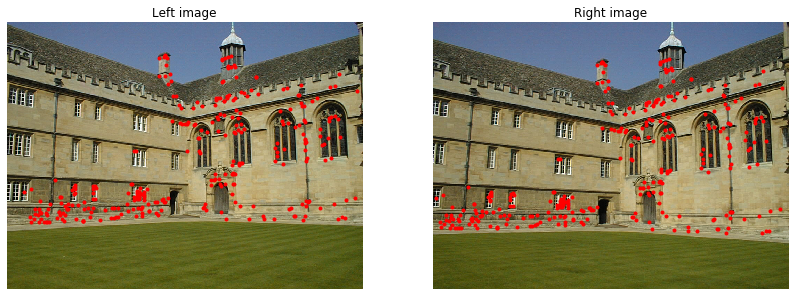

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Load image pair and convert to RGB
left = cv2.imread('left.jpg')
right = cv2.imread('right.jpg')
left = cv2.cvtColor(left,cv2.COLOR_BGR2RGB)
right = cv2.cvtColor(right,cv2.COLOR_BGR2RGB)

# Load 2D points (2xN matrices)
pts1 = np.load('pts1.npy')
pts2 = np.load('pts2.npy')

# Load 3D points (3xN matrix)
pts3D = np.load('pts3D.npy')

# Display 2D point correspondences
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(left)
plt.plot(pts1[0,:],pts1[1,:], '.r')
plt.title('Left image')
plt.axis('off')
plt.subplot(122)
plt.imshow(right)
plt.plot(pts2[0,:],pts2[1,:], '.r')
plt.title('Right image')
plt.axis('off')


The camera projection matrices $\mathbf{C}$ and $\mathbf{C}'$ are also provided for both views.

In [2]:
# Load 3x4 camera projection matrices
C1 = np.load('C1.npy')
C2 = np.load('C2.npy')

## 2. From 3D points to 2D points

With the camera matrix $\mathbf{C} = \mathbf{K}[\mathbf{R} | \mathbf{t}]$ we can project 3D points to 2D points on the image plane:

$$
s \begin{pmatrix}u \\ v \\ 1 \end{pmatrix} = \mathbf{C} \begin{pmatrix} X \\ Y \\ Z \\ 1 \end{pmatrix} \qquad \qquad (1)
$$

Note that we are using homogeneous coordinates.

**2.1. Project 3D points** $\quad$ <font color=red>(0.50 points)</font>

Complete the function `projectPts()` by following the instructions below. The function should project 3D points `pts3D` to 2D image points `pts2D`. The result should look like the previous figure.


(-0.5, 1023.5, 767.5, -0.5)

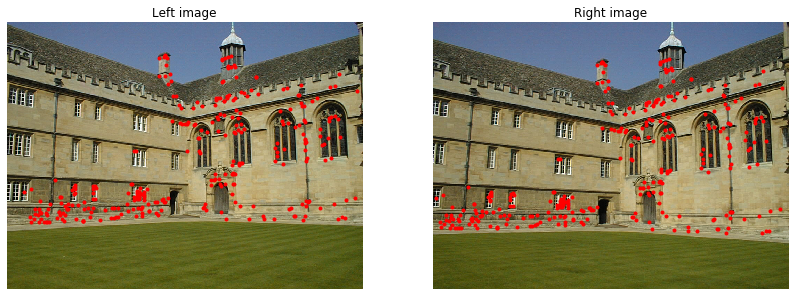

In [3]:
# INPUT   
# pts3D : 3D points (X,Y,Z) (3xN matrix)
# C     : Camera projection matrix (3x4 matrix)
#
# OUTPUT  
# pts2D : 2D points (x,y) (2xN matrix)
#
def projectPts(pts3D,C):
    
    N = pts3D.shape[1] # Number of points
    
    # ---------- YOUR CODE STARTS HERE -----------
    
    # This line can be removed
    #pts2D = np.zeros((2,N), dtype=np.float_)
        
    # 1. Convert 3D points from Euclidean to 
    #    homogeneous coordinates (4xN matrix)
    pts3D = np.vstack( (pts3D, np.ones((1,N))) )
    
    # 2. Project points using Equation 1
    pts2D = C.dot(pts3D)
    
    # 3. Covert 2D points from homogeneous to 
    #    Euclidean coordinates (2xN matrix)
    #pts2D[0,:] = pts2D[0,:]/pts2D[2,:]
    #pts2D[1,:] = pts2D[1,:]/pts2D[2,:]
    pts2D[:-1,:] = pts2D[:-1,:] / pts2D[-1,:] 
    
    # ----------- YOUR CODE ENDS HERE ------------

    return pts2D


# Project 3D points and visualize the result
points1 = projectPts(pts3D,C1)
points2 = projectPts(pts3D,C2)

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(left)
plt.plot(points1[0,:],points1[1,:], '.r')
plt.title('Left image')
plt.axis('off')
plt.subplot(122)
plt.imshow(right)
plt.plot(points2[0,:],points2[1,:], '.r')
plt.title('Right image')
plt.axis('off')

In [4]:
def projectPts_test(pts3D,C):
    N = pts3D.shape[1]
    pts3D = np.vstack( (pts3D, np.ones((1,N))) )
    pts2D = C.dot(pts3D)  
    pts2D[:-1,:] = pts2D[:-1,:] / pts2D[-1,:] 
    return pts2D

np.testing.assert_almost_equal(projectPts(pts3D,C1), 
                               projectPts_test(pts3D,C1), 
                               decimal = 3,
                               err_msg = "The projectPts() function seems to be wrong.")

## 3. From 2D points to 3D points

The lecture notes describe a linear method to triangulate a point observed in two cameras (slide 196).
Given a point $\mathbf{X} = (X,Y,Z)^{\top}$ the projection equations are:

$$
\begin{pmatrix}
s u \\ 
s v \\
s \end{pmatrix} = 
\begin{pmatrix}
c_{11} & c_{12} & c_{13} & c_{14} \\ 
c_{21} & c_{22} & c_{23} & c_{24} \\
c_{31} & c_{32} & c_{33} & c_{34} \end{pmatrix}
\begin{pmatrix}
X \\ 
Y \\
Z \\
1 \end{pmatrix}
$$

$$
\begin{pmatrix}
t u' \\ 
t v' \\
t \end{pmatrix} = 
\begin{pmatrix}
c_{11}' & c_{12}' & c_{13}' & c_{14}' \\ 
c_{21}' & c_{22}' & c_{23}' & c_{24}' \\
c_{31}' & c_{32}' & c_{33}' & c_{34}' \end{pmatrix}
\begin{pmatrix}
X \\ 
Y \\
Z \\
1 \end{pmatrix}
$$

Here we have used the same notation as in the exercises. Eliminating $s$ and $t$ we obtain the system of equations:

$$
(c_{31} u - c_{11}) X + (c_{32} u - c_{12}) Y + (c_{33} u - c_{13}) Z = c_{14} - c_{34} u \\
(c_{31} v - c_{21}) X + (c_{32} v - c_{22}) Y + (c_{33} v - c_{23}) Z = c_{24} - c_{34} v \\
(c_{31}' u' - c_{11}') X + (c_{32}' u' - c_{12}') Y + (c_{33}' u' - c_{13}') Z = c_{14}' - c_{34}' u' \\
(c_{31}' v' - c_{21}') X + (c_{32}' v' - c_{22}') Y + (c_{33}' v' - c_{23}') Z = c_{24}' - c_{34}' v'
$$

which can be expressed in a linear system of the form: $\mathbf{Ax} = \mathbf{b}$ and solved using the least squares method. *See the Exercise 8 (Q2)*. <br>Notice also that equations are different from the ones presented in the lecture slides.

**3.1. Triangulate** $\quad$ <font color=red>(1.50 points)</font>

Complete the function `triangulatePts()`. Estimate 3D points given 2D points `pts1` and `pts2` and projection matrices `C1` and `C2`. For each point, form a linear system $\mathbf{Ax} = \mathbf{b}$, where $\mathbf{A}$ is a $4 \times 3$ matrix and $\mathbf{b}$ is a $4 \times 1$ vector. The least-squares solution can be obtained by $\hat{\mathbf{x}} = (\mathbf{A}^{\top} \mathbf{A})^{-1} \mathbf{A}^{\top} \mathbf{b}$, where $\hat{\mathbf{x}}$ contains the coordinates of the 3D point $(X,Y,Z)$. Once you have completed the function, execute the following code cell. The implementation is correct if the estimated 3D points `points3D` overlap with the given 3D points `pts3D`.

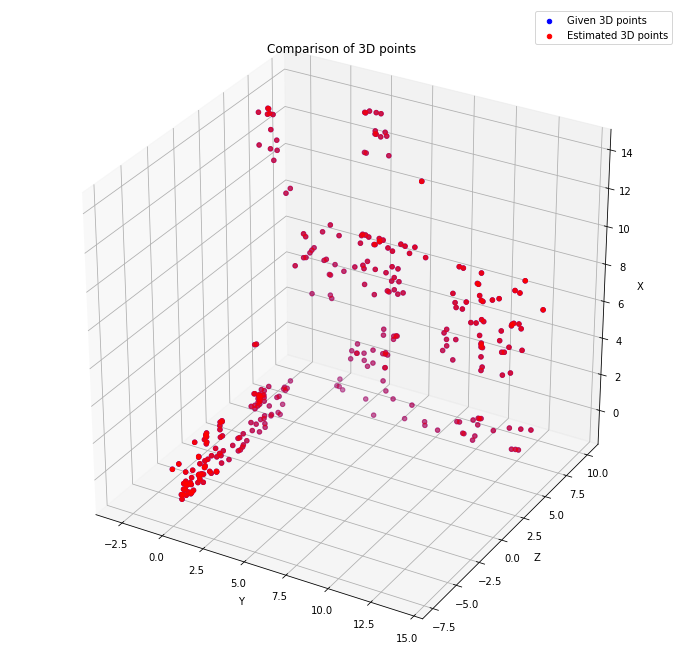

In [5]:
# INPUT   
# pts1 : 2D points from the first image (2xN matrix)
# pts2 : 2D points from the second image (2xN matrix)
# C1   : Camera matrix for the first image (3x4 matrix)
# C2   : Camera matrix for the second image (3x4 matrix)
#
# OUTPUT  
# pts3D : Triangulated 3D points (X,Y,Z) (3xN matrix)
#
def triangulatePts(pts1,pts2,C1,C2):
    
    N = pts1.shape[1] # Number of points
    pts3D = np.zeros((3,N),dtype=np.float_)
    
    # ---------- YOUR CODE STARTS HERE -----------
    
    # 1. For each point i, form A and b
    A = np.zeros((4,3), dtype=np.float_)
    b = np.zeros((4,1), dtype=np.float_)

    for i in range(N):
        
        A[0,0] = pts1[0,i]*C1[2,0] - C1[0,0]
        A[0,1] = pts1[0,i]*C1[2,1] - C1[0,1]
        A[0,2] = pts1[0,i]*C1[2,2] - C1[0,2]
        A[1,0] = pts1[1,i]*C1[2,0] - C1[1,0]
        A[1,1] = pts1[1,i]*C1[2,1] - C1[1,1]
        A[1,2] = pts1[1,i]*C1[2,2] - C1[1,2]
        
        A[2,0] = pts2[0,i]*C2[2,0] - C2[0,0]
        A[2,1] = pts2[0,i]*C2[2,1] - C2[0,1]
        A[2,2] = pts2[0,i]*C2[2,2] - C2[0,2]
        A[3,0] = pts2[1,i]*C2[2,0] - C2[1,0]
        A[3,1] = pts2[1,i]*C2[2,1] - C2[1,1]
        A[3,2] = pts2[1,i]*C2[2,2] - C2[1,2]
        
        b[0,0] = C1[0,3] - pts1[0,i]*C1[2,3]
        b[1,0] = C1[1,3] - pts1[1,i]*C1[2,3]
        b[2,0] = C2[0,3] - pts2[0,i]*C2[2,3]
        b[3,0] = C2[1,3] - pts2[1,i]*C2[2,3]
    
        # 2. Find solution to linear system Ax=b
        x = np.linalg.inv(A.T.dot(A)).dot(A.T).dot(b)
    
        # 3. Save the triangulated point to pts3D[i,:]
        pts3D[:,i] = x.T

    # ----------- YOUR CODE ENDS HERE ------------

    return pts3D


# Triangulate points and compare to given 3D points
points3D = triangulatePts(pts1,pts2,C1,C2)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-pts3D[1,:],pts3D[2,:],-pts3D[0,:], 
           color='blue', label='Given 3D points')
ax.scatter(-points3D[1,:],points3D[2,:],-points3D[0,:], 
           color='red', label='Estimated 3D points')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
ax.set_zlabel('X')
ax.set_title('Comparison of 3D points')
ax.legend()


In [6]:
np.testing.assert_almost_equal(pts3D, 
                               points3D, 
                               decimal = 2,
                               err_msg = "The points don't seem to overlap.")

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

# References
`LIST YOUR POSSIBLE REFERENCES HERE!`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A8.ipynb` file) into **`MV_A8_[student number(s)].zip`** (e.g. `MV_A8_1234567.zip` if solo work or `MV_A8_1234567-7654321.zip` if pair work).
3. Send an email to janne.mustaniemi@oulu.fi with the subject line `MV_A8_[student number(s)]`. Remember to attach the .zip file.

**Deadline of the assignment 11.3.2020**